In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

In [2]:
root_dir = os.getcwd()
print(root_dir)

# root_data_dir = os.path.join(root_dir, 'data/torobo/trajs:2000_blocks:3_random')
root_data_dir = os.path.join(root_dir, 'data/torobo/trajs:360_blocks:3_triangle')
print(root_data_dir)

/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network
/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/data/torobo/trajs:360_blocks:3_triangle


In [3]:
raw_ds_path = os.path.join(root_data_dir, 'raw.npy')
raw_ds_array = np.load(raw_ds_path, allow_pickle=True, encoding='latin1')
raw_ds_array.shape

(360, 300, 6)

### Raw data to np array

In [4]:
episodes_list = []

for i in range(0, raw_ds_array.shape[0]):
    timestep_list = []
    for j in range(0, raw_ds_array.shape[1]):
        data_timestep = raw_ds_array[i, j]
        
        timestep = data_timestep[0]
        joint_values = data_timestep[1] #(7, )
        target_A_pos = data_timestep[2]
        target_B_pos = data_timestep[3]
        target_C_pos = data_timestep[4]
        one_hot = data_timestep[5]

        targets_pos = np.concatenate((target_A_pos, target_B_pos, target_C_pos), axis=0) #(9, )
        targets_pos = np.concatenate((targets_pos, one_hot), axis=0) #(13, )

        tmp_list = [timestep]
        for k in range(len(joint_values)):
            tmp_list.append(joint_values[k])
        for k in range(targets_pos.size):
            tmp_list.append(targets_pos[k])

        timestep_list.append(tmp_list)
    episodes_list.append(timestep_list)

In [5]:
torobo_data = np.array(episodes_list)
print(torobo_data.shape)

(360, 300, 21)


In [6]:
trajs_path = os.path.join(root_data_dir, 'trajs_np.npy')
with open(trajs_path, 'wb') as f:
    np.save(f, torobo_data)

In [7]:
with open(trajs_path, 'rb') as f:
    torobo_data = np.load(f)
print(torobo_data.shape)
print(torobo_data.dtype)

(360, 300, 21)
float64


In [8]:
steps = torobo_data[:, :, 0]
joint_values = torobo_data[:, :, 1:8]
target_points = torobo_data[:, :, 8:]
print(steps.shape)
print(joint_values.shape)
print(target_points.shape)

(360, 300)
(360, 300, 7)
(360, 300, 13)


### Get velocity and actions

In [9]:
def calculate_vel_act(array, start_idx, end_idx):
    vel_episodes, act_episodes = [], []
    for i in range(array.shape[0]):
        vel_steps, act_steps = [], []
        
        for j in range(array.shape[1]):
            cur_vals = array[i][j][start_idx:end_idx]
            if j != 0:
                prev_vals = array[i][j-1][start_idx:end_idx]
            else: 
                prev_vals = cur_vals

            if j < array.shape[1]-1: # !=
                next_vals = array[i][j+1][start_idx:end_idx]

                vel_steps.append((cur_vals - prev_vals) / (100 / 150))
                act_steps.append(next_vals - cur_vals)
        vel_episodes.append(vel_steps)
        act_episodes.append(act_steps)

    return np.array(vel_episodes), np.array(act_episodes)
    #return np.array(act_episodes)

In [10]:
velocs, acts = calculate_vel_act(joint_values, 0 , 7)

print("Joints:")
print(joint_values.shape)
print(joint_values[2][0][:])
print(joint_values[2][1][:])

print('Velocs:')
print(velocs.shape)
print(velocs[2][0][:])
print(velocs[2][1][:])

print('Acts:')
print(acts.shape)
print(acts[2][0][:])
print(acts[2][1][:])

Joints:
(360, 300, 7)
[ 1.5139664   1.19930224  1.23330487  1.35387344 -0.59584933  1.14362789
  0.5735987 ]
[ 1.49410441  1.18743548  1.22419212  1.37472994 -0.59292342  1.12674565
  0.58177462]
Velocs:
(360, 299, 7)
[0. 0. 0. 0. 0. 0. 0.]
[-0.02979298 -0.01780014 -0.01366913  0.03128476  0.00438888 -0.02532335
  0.01226388]
Acts:
(360, 299, 7)
[-0.01986199 -0.01186676 -0.00911275  0.02085651  0.00292592 -0.01688224
  0.00817592]
[-0.01985428 -0.01185322 -0.00911613  0.02082449  0.00291666 -0.01689023
  0.00816537]


### Visualization

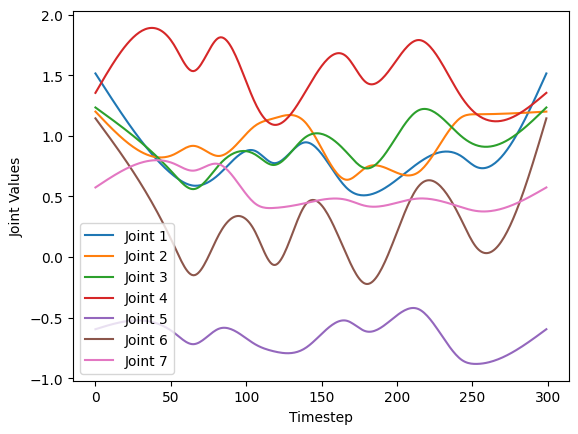

In [11]:
episode_num = 10
sample_vals = joint_values[episode_num, :, :]
# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column in the array
for i in range(sample_vals.shape[1]):
    ax.plot(sample_vals[:, i], label=f'Joint {i+1}')

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Joint Values')
ax.legend()

# Show the plot
plt.show()

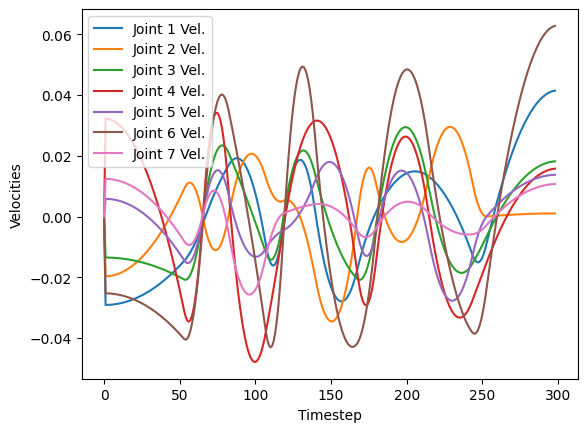

In [12]:
episode_num = 10
sample_vals = velocs[episode_num, :, :]
# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column in the array
for i in range(sample_vals.shape[1]):
    ax.plot(sample_vals[:, i], label=f'Joint {i+1} Vel.')

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Velocities')
ax.legend()

# Show the plot
plt.show()

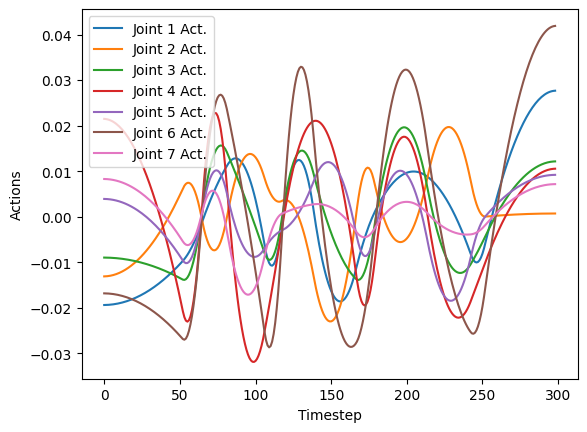

In [13]:
episode_num = 10
sample_vals = acts[episode_num, :, :]
# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column in the array
for i in range(sample_vals.shape[1]):
    ax.plot(sample_vals[:, i], label=f'Joint {i+1} Act.')

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Actions')
ax.legend()

# Show the plot
plt.show()

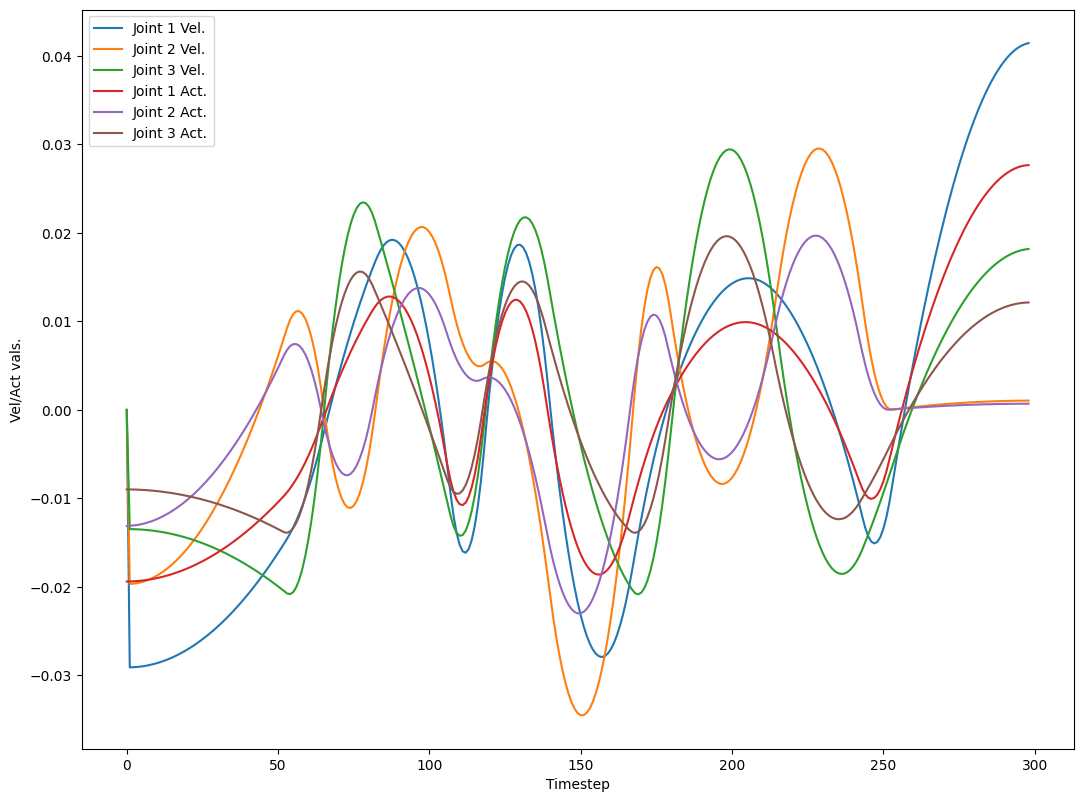

In [14]:
episode_num = 10
sample_vel_vals = velocs[episode_num, :, :]
sample_act_vals = acts[episode_num, :, :]
# Create a figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(12.8, 9.6)

# Plot each column in the array
for i in range(3):
    ax.plot(sample_vel_vals[:, i], label=f'Joint {i+1} Vel.')
for i in range(3):
    ax.plot(sample_act_vals[:, i], label=f'Joint {i+1} Act.')

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Vel/Act vals.')
ax.legend()

# Show the plot
plt.show()

### Reducing last step:

In [15]:
print(steps.shape)
print(joint_values.shape)
print(target_points.shape)

steps = steps[:, :-1]
joint_values = joint_values[:, :-1, :]
target_points = target_points[:, :-1, :]

print("After reduction:")
print(steps.shape)
print(joint_values.shape)
print(target_points.shape)

(360, 300)
(360, 300, 7)
(360, 300, 13)
After reduction:
(360, 299)
(360, 299, 7)
(360, 299, 13)


### Mean, STD, Min, Max

In [16]:
print("- Joints -")
print(joint_values.shape)
print(np.mean(joint_values, axis=(0, 1)))
print(np.std(joint_values, axis=(0, 1)))
print(np.max(joint_values, axis=(0, 1)))
print(np.min(joint_values, axis=(0, 1)))

print("- Velocity -")
print(velocs.shape)
print(np.mean(velocs, axis=(0, 1)))
print(np.std(velocs, axis=(0, 1)))
print(np.max(velocs, axis=(0, 1)))
print(np.min(velocs, axis=(0, 1)))

print("- Action -")
print(acts.shape)
print(np.mean(acts, axis=(0, 1)))
print(np.std(acts, axis=(0, 1)))
print(np.max(acts, axis=(0, 1)))
print(np.min(acts, axis=(0, 1)))

- Joints -
(360, 299, 7)
[ 0.82386829  0.921646    0.90085648  1.5363147  -0.62805662  0.28958567
  0.55386801]
[0.23618165 0.20458603 0.18394481 0.24528422 0.12910712 0.32986085
 0.13122397]
[ 1.5139664   1.26672041  1.32549757  2.01966023 -0.30752916  1.14362789
  0.82003282]
[ 0.38430965  0.40667287  0.43440792  0.90992367 -0.90864395 -0.35012253
  0.26322444]
- Velocity -
(360, 299, 7)
[-1.43318546e-04 -2.91244811e-05 -6.87767855e-05 -8.54857852e-06
 -3.64115265e-05 -1.94474696e-04 -1.68266829e-05]
[0.01881365 0.01526987 0.01559752 0.02231899 0.0108464  0.032278
 0.00963601]
[0.04495834 0.04423867 0.03141072 0.05662538 0.02549894 0.0645631
 0.03751363]
[-0.03066852 -0.03802747 -0.03157383 -0.04788183 -0.03103814 -0.04588633
 -0.03701841]
- Action -
(360, 299, 7)
[ 4.12568943e-20  5.15711178e-21 -1.13456459e-20 -8.25137885e-21
 -9.28280121e-21  3.74406315e-19 -1.03142236e-21]
[0.01265131 0.01018726 0.01043093 0.01488256 0.00724362 0.0216358
 0.00643024]
[0.02999543 0.02949245 0.0209

### Creating final dataset

In [17]:
train_ds = steps[:, :, np.newaxis] #1

train_ds = np.concatenate((train_ds, joint_values), #7
                             axis=2)
train_ds = np.concatenate((train_ds, velocs), #7
                             axis=2)
train_ds = np.concatenate((train_ds, target_points), #13
                             axis=2)
train_ds = np.concatenate((train_ds, acts), #7
                             axis=2)
print(train_ds.shape)

(360, 299, 35)


In [18]:
train_ds_path = os.path.join(root_data_dir, 'train_ds.npy')
with open(train_ds_path, 'wb') as f:
    np.save(f, train_ds)

### Targets Visualization

Text(0.5, 0, 'Z Label')

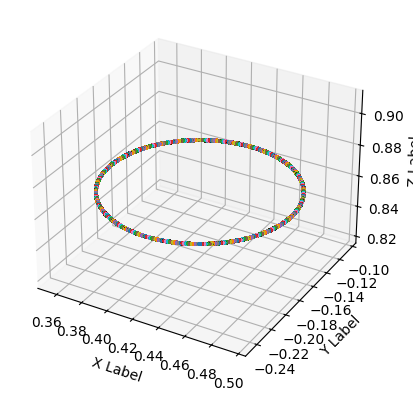

In [23]:
# Create a figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
for i in range(target_points.shape[0]): #range(5): #target_points.shape[0]
    size = 3
    # print(i, target_points[i])
    x = target_points[i, :, 0]
    y = target_points[i, :, 1]
    z = target_points[i, :, 2]
    ax.scatter(x, y, z, s=size)

    x = target_points[i, :, 3]
    y = target_points[i, :, 4]
    z = target_points[i, :, 5]
    ax.scatter(x, y, z, s=size)

    x = target_points[i, :, 6]
    y = target_points[i, :, 7]
    z = target_points[i, :, 8]
    ax.scatter(x, y, z, s=size)

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')